In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def generate_gaussian_steps(num_steps):
    """Generate X_1 to X_n that are iid gaussian """
    X = np.random.normal(size=num_steps)
    return X

def generate_gaussian_steps_dt(num_steps, dt):
    """Generate X_1 to X_n that are iid gaussian """
    X = np.random.normal(size=num_steps)
    return X*np.sqrt(dt)

def generate_random_walk_path(steps, n):
    """Generate a random walk that is shrunk in space and sped up in time from a sequence of steps
        steps size: n*t
        return size: t
    """
    Y = np.array([0])
    for k in range(n):
        Y = np.concatenate( (Y, np.cumsum(steps[0:k+1])/np.sqrt(n) ) )
    return Y



### Question 1

\begin{eqnarray}
    \Delta W_n = W(t_{n+1}) - W(t_n) \\
            Y_t = Y_0 \exp{ (\mu-\sigma^2/2)t + \sigma W_t }
\end{eqnarray}

## MLMC Questions

### 1. Simulate Geometric Brownian Motion

In [4]:
def generate_geometric_brownian_motion(dW, N, dt):
    '''
    Euler Maruyama IntEgration
    '''
    time = [0]
    Y = [1.0]
    mu = 0.05
    sigma = 0.2
    for n in range(N):
        Y_n = Y[-1]
        bt = mu*Y_n
        ht = sigma*Y_n
        delta_W = dW[n]
        Y_next = Y_n + bt*dt + ht*delta_W
        Y.append(Y_next)
        t = time[-1] + dt
        time.append(t)
    return np.asarray(Y), time

### 4.1 (1)

In [5]:
TF = 1
N_DIVISIONS = 100
dt = TF/N_DIVISIONS
num_trials = 1000
num_samples = int(np.ceil(TF/dt))
estimator_vals = np.zeros((num_trials, num_samples+1))
for trial in range(num_trials):
    delta_W = generate_gaussian_steps_dt(num_samples,dt)  # Use these as Delta W_n
    estimator_vals[trial, :], _ = generate_geometric_brownian_motion(delta_W, num_samples, dt)

shape (1000, 101)


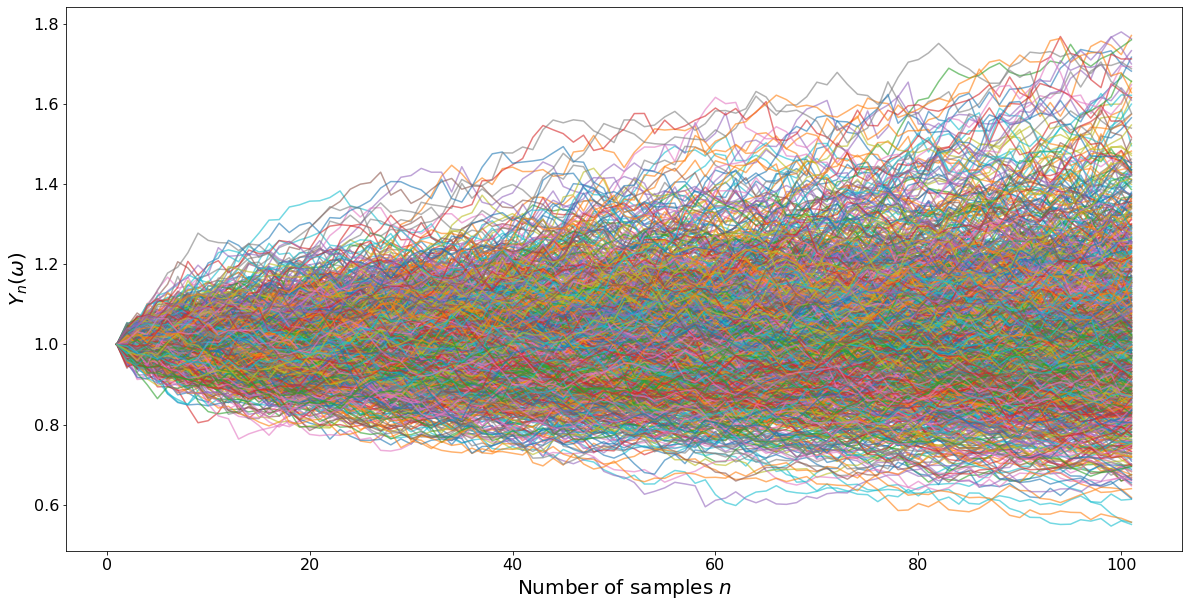

In [6]:
print("shape",np.shape(estimator_vals))
plt.figure(figsize=(20,10))
plt.plot(np.arange(1, num_samples+2), estimator_vals.T, alpha=0.6)
plt.ylabel(r'$Y_n(\omega)$', fontsize=20)
plt.xlabel(r'Number of samples $n$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.show()

In [7]:
index_1 = int(1.0/dt)
print("Mean at 1 = ", np.mean(estimator_vals[:,index_1]))
print("Variance at 1 = ", np.var(estimator_vals[:,index_1]))

Mean at 1 =  1.0365666689542596
Variance at 1 =  0.0441650346300319


#### Analytic Mean of Y(1)

\begin{eqnarray}
            Y_t = Y_0 e^{ (\mu-\sigma^2/2)t + \sigma W_t } \\
            E[Y_t] = Y_0 e^{\mu-\sigma^2/2}E[e^{\sigma W_t}]
\end{eqnarray}

### 4.1 (2)

In [8]:
def brownian_fine_to_coarse(T, dt, brownian_fine, M):
    num_samples =  int(np.ceil(T/dt)) + 1
    num_paths = brownian_fine.shape[0]
    brownian_coarse = np.zeros((num_paths, num_samples))
    brownian_coarse[:,0] = brownian_fine[:,0]
    for ii in range(1, num_samples):
        delta = brownian_fine[:, ii * M] - brownian_fine[:, (ii-1)*M]
        brownian_coarse[:, ii] = brownian_coarse[:, ii-1] + delta
    return brownian_coarse
    

### (2) Now simulate 2 processes with different dts

In [9]:
M = 4
DT =  0.01  # fine scale time step
DTM = DT * M # coarse scale time step
TFINAL = 1.0 # final time
TSPAN_COARSE = np.arange(0, TFINAL + DTM, DTM)
TSPAN_FINE = np.arange(0, TFINAL+DT, DT)
# delta_W = generate_gaussian_steps_dt(num_samples,DT)  # Use these as Delta W_n
# brownian_fine = generate_geometric_brownian_motion(delta_W, num_samples)

num_trials = 1000
brownian_fine = np.zeros((num_trials, num_samples+1))
geometric_fine = np.zeros((num_trials, num_samples+1))
for trial in range(num_trials):
    brownian_fine[trial, :] = generate_gaussian_steps_dt(num_samples+1,DT)  # Use these as Delta W_n   
    geometric_fine[trial, :], times_fine = generate_geometric_brownian_motion(brownian_fine[trial,:], num_samples, DT)

print("shapes")
print(np.shape(geometric_fine),len(times_fine))
brownian_coarse = brownian_fine_to_coarse(TFINAL, DTM, brownian_fine, M)

num_samples_coarse = int(np.ceil(TFINAL/DTM)) + 1
geometric_coarse = np.zeros((num_trials, num_samples_coarse+1))
for trial in range(num_trials):
    geometric_coarse[trial, :], times_coarse = generate_geometric_brownian_motion(brownian_coarse[trial,:], num_samples_coarse, DTM)

# Geometric motion


shapes
(1000, 101) 101


### Plotting means of fine and coarse motions

shape (1000, 101)


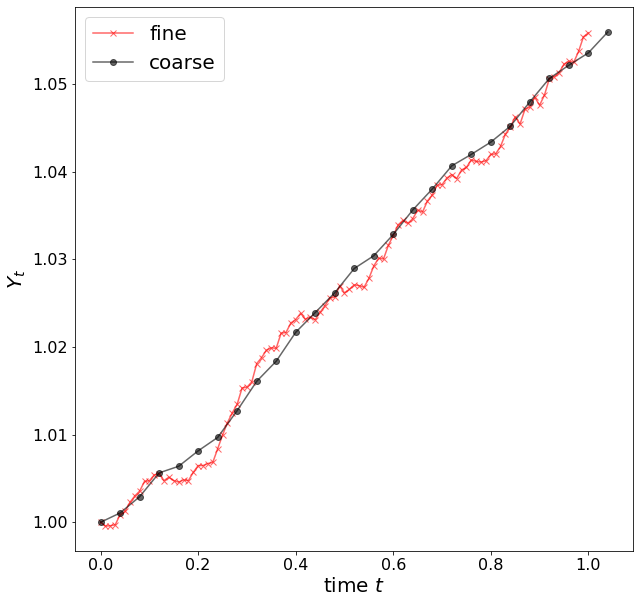

In [10]:
print("shape",np.shape(estimator_vals))
plt.figure(figsize=(10,10))
plt.plot(times_fine, np.mean(geometric_fine,axis=0), 'r-x', alpha=0.6, label='fine')
plt.plot(times_coarse, np.mean(geometric_coarse,axis=0), 'k-o', alpha=0.6, label='coarse')
plt.legend(fontsize=20)
plt.ylabel(r'$Y_t$', fontsize=20)
plt.xlabel(r'time $t$', fontsize=20)
plt.xticks(fontsize=16)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.yticks(fontsize=16)
plt.show()

### (3) Multi Level Monte Carlo

Level 0 is lowest fidelity model
Level 3 is high fidelity model

\begin{eqnarray}
             E[X_L] = \underbrace{E[X_0]}_{level~ 0 ~term} + \underbrace{E[X_1-X_0]}_{level~ 1 ~term} + \underbrace{E[X_2-X_1]}_{level~ 2 ~term}  + \underbrace{E[X_3-X_2]}_{level~ 3 ~term} 
\end{eqnarray}

We expect variance to reduce with each level. The plot below will verify that.
Each of term above should have independent samples.
However, within each term, say $X_1-X_0$, they should be generated from same underlying process. Therefore in this term X_0 is produced using coarsed version of X_1's brownian motion component as done above in part (2)

Y1 1.066228130984424
Means [1.0592454180713105, 0.0011965761126632632, 0.006380212350202724, -0.0005940755497526932]
Variances [0.047567150886924425, 0.035619675745645826, 0.032245239950681195, 0.035260899868914]


Text(0.5, 0, 'Level')

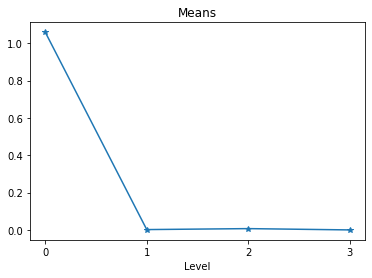

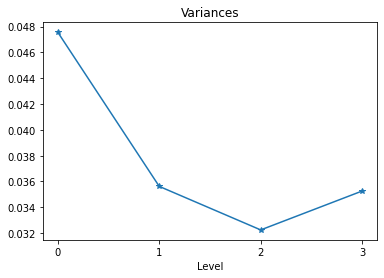

In [15]:
def generate_geometric_motion(DT, TFINAL, num_trials):
    num_samples = int(np.ceil(TFINAL/DT)) + 1
    brownian_ = np.zeros((num_trials, num_samples+1))
    geometric_ = np.zeros((num_trials, num_samples+1))
    for trial in range(num_trials):
        brownian_[trial, :] = generate_gaussian_steps_dt(num_samples+1,DT)  # Use these as Delta W_n   
        geometric_[trial, :], times_fine = generate_geometric_brownian_motion(brownian_[trial,:], num_samples, DT)
    return geometric_, brownian_

def generate_coarse_geometric_from_brownian(brownian_fine, TFINAL, DT1, DT2, num_trials):
    brownian_coarse = brownian_fine_to_coarse(TFINAL, DT2, brownian_fine, int(DT2/DT1))
    num_samples_coarse = int(np.ceil(TFINAL/DT2)) + 1
    geometric_coarse = np.zeros((num_trials, num_samples_coarse+1))
    for trial in range(num_trials):
        geometric_coarse[trial, :], times_coarse = generate_geometric_brownian_motion(brownian_coarse[trial,:], num_samples_coarse, DT2)
    return geometric_coarse
    

TFINAL = 1.0 # final time

DT1 = 4**(-2)  # time step 1
DT2 = 4**(-3)  # time step 2
DT3 = 4**(-4)  # time step 3
DT4 = 4**(-5)  # time step 4

num_trials = 1000

# Level 0
geometric_fine, _ = generate_geometric_motion(DT1, TFINAL, num_trials)
level_0 = geometric_fine[:,-1] # data only for last (T=1) element

# Level 1
geometric_fine, brownian_fine = generate_geometric_motion(DT2, TFINAL, num_trials)
geometric_coarse = generate_coarse_geometric_from_brownian(brownian_fine, TFINAL, DT2, DT1, num_trials)
level_1 = geometric_fine[:,-1] - geometric_coarse[:,-1]

# Level 2
geometric_fine, brownian_fine = generate_geometric_motion(DT3, TFINAL, num_trials)
geometric_coarse = generate_coarse_geometric_from_brownian(brownian_fine, TFINAL, DT3, DT2, num_trials)
level_2 = geometric_fine[:,-1] - geometric_coarse[:,-1]

# Level 3
geometric_fine, brownian_fine = generate_geometric_motion(DT4, TFINAL, num_trials)
geometric_coarse = generate_coarse_geometric_from_brownian(brownian_fine, TFINAL, DT4, DT3, num_trials)
level_3 = geometric_fine[:,-1] - geometric_coarse[:,-1]

# Expectation at Y(1) with MLMC
Y1 = np.mean(level_0) + np.mean(level_1) + np.mean(level_2) + np.mean(level_3)
print("Y1", Y1)

# Expectations of each level across
means = [np.mean(level_0), np.mean(level_1), np.mean(level_2), np.mean(level_3)]
print("Means", means)
plt.figure()
x = [0,1,2,3]
plt.plot(x,means,'*-')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Means")
plt.xlabel('Level')

# Variances of each level
variances = [np.std(level_0)**2, np.std(level_1)**2, np.std(level_2)**2, np.std(level_3)**2]
print("Variances", variances)
plt.figure()
x = [0,1,2,3]
plt.plot(x,variances,'*-')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.title("Variances")
plt.xlabel('Level')





The variance with each level reduces. That's good!
The level_0 mean is high and is representative of true values. The remaining means are correction terms and are therefore close to 0

### (4) Theoretical Cost of MLMC estimator

Copy from supplementary material given in course on MLMC. Need to make a plot using those expressions

### (5) Plot equalent samples of MC and MLMC

1.0045151242115722


Text(0, 0.5, 'Number of Samples of High-fidely model')

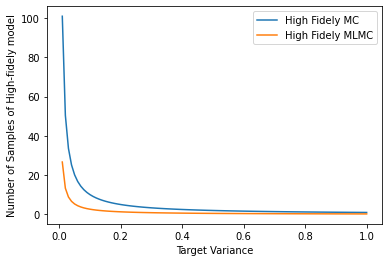

In [35]:
print( np.sqrt(1*variances[0]) + np.sqrt(2*variances[1]) + np.sqrt(2*variances[2]) + np.sqrt(2*variances[3]) )
epsilon_sq = np.linspace(0.01,1,100)
sum_roots =  np.sqrt(1*variances[0]) + np.sqrt(2*variances[1]) + np.sqrt(2*variances[2]) + np.sqrt(2*variances[3])
N3_mc = 1/epsilon_sq*sum_roots**2
N3_mlmc = 1/epsilon_sq * sum_roots*  np.sqrt( variances[3]*2 )
plt.plot(epsilon_sq,N3_mc, label='High Fidely MC')
plt.plot(epsilon_sq,N3_mlmc, label='High Fidely MLMC')
plt.legend()
plt.xlabel('Target Variance')
plt.ylabel('Number of Samples of High-fidely model')